In [1]:
# Author: Matteo Serafino, 2023
#
# This notebook focuses on the analyses presented in Section two of the reference paper.
# 
# Before proceeding, make sure to run "section_two_*_utilities.py" which creates part
# of the necessary files for the analyses.

In [2]:
from pprint import pprint

from random import sample
import scipy.sparse as sp
import numpy as np
import pickle
import glob

import pandas as pd
import json
from tqdm import tqdm

from collections import Counter
from collections import defaultdict

import graph_tool.all as gt
import networkx as nx

from pygenstability import plotting, constructors
from pygenstability.optimal_scales import identify_optimal_scales

from general_utilities import build_CI_rank,get_get_outliers

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np

gran_path = '/sdf/MatteoPaper/'
raw_data_path = gran_path + 'rawdata/'
edgelist_path = gran_path + 'edgelist/'
section_two_path = gran_path + 'section_two/'
categories_net = gran_path + 'categories_networks/'
section1_data_path = gran_path + 'section_one/' 
section_three_path = gran_path + 'section_three/'

media_types = ['fake', 'far_right', 'right', 'lean_right',
               'center', 'lean_left', 'left','far_left']
    
    
abbr_to_good = {'far_right':'Extreme bias right',
              'fake':'Fake','right':'Right',
              'center':'Center','lean_left':'Left leaning',
              'left':'Left','lean_right':'Right leaning',
              'far_left':'Extreme bias Left'}

#top infleuncers per category: from section one
infleuncers_per_cat = json.load(open(categories_net + 'top_infleuncers.txt'))

#user acconts info 
users_account = json.load(open(section1_data_path+'users_accounts.txt'))

#users supportings info
supporters_info = json.load(open(section_two_path + 'users_support.txt'))

user_strump2,users_opinion = {},{}
for user in supporters_info:
    S = supporters_info[user][1] - supporters_info[user][0]
    user_strump2[user] = S
    if S > 0: 
        users_opinion[user] = 'T' 
    elif S < 0:
        users_opinion[user] = 'C' 
    else:
        users_opinion[user] = 'U' 
        
        
#TO DO: improve this part
import sys
sys.path.append('/home/matteo/IRA_paper/fake_news_during_election/')


from fake_identify import Are_you_IRA

Putin = Are_you_IRA()

In [2]:
#set expanded to True if you want to analyze the expande d network
expanded = False

In [3]:
if expanded:

    
    files=glob.glob('/home/matteo/IRA_paper/com_results/und_expanded/expresults_60_1_075.pkl')
    G = nx.read_gpickle(section_three_path+'expanded_ego.gp')
    hash_table=pd.read_csv(section_three_path + 'expanded_hashtags.txt',names=['from','to','hash'])
    
    #this is just temporary
    temporary = json.load(open(section_three_path +'temporary.txt'))
    G=G.subgraph(list(temporary.values()))
    
    ego_nodes = set(list(nx.read_gpickle(section_two_path + 'aggregated_ego.gp').nodes()))

    Putin.IRA_user_set = set([i for i,j in users_account.items() if \
                (len(i)!=64 and \
                 i in ego_nodes and \
                 users_account[i]=='Suspended')]) \
                .union(Putin.IRA_user_set)
    
else:

    files = glob.glob(section_two_path + 'communnity_det/results_30_2_075.pkl')
    G = nx.read_gpickle(section_two_path + 'aggregated_ego.gp')
    hash_table=pd.read_csv(section_two_path + 'aggragted_hashtags.txt',names=['from','to','hash'])
    
#Consider the largest connected component
largest_cc = max(nx.weakly_connected_components(G), key=len)

print('The largest conected component preserves ', round(len(largest_cc)/len(G.nodes())*100,2), '% of the original nodes.')

G = G.subgraph(largest_cc).copy()    

The largest conected component preserves  99.94 % of the original nodes.


In [4]:
 files = glob.glob(section_two_path + 'communnity_det/results_30_2_075.pkl')

In [5]:
if not expanded: 
    for i,media_type in enumerate(media_types[:-1]):
        for j,media_typee in enumerate(media_types[i+1:]):
            print(media_type,media_typee, len(set(infleuncers_per_cat[media_type])  & set(infleuncers_per_cat[media_typee]) ) )

fake far_right 40
fake right 31
fake lean_right 24
fake center 10
fake lean_left 3
fake left 0
fake far_left 0
far_right right 43
far_right lean_right 35
far_right center 16
far_right lean_left 3
far_right left 0
far_right far_left 0
right lean_right 36
right center 19
right lean_left 3
right left 0
right far_left 0
lean_right center 22
lean_right lean_left 4
lean_right left 2
lean_right far_left 0
center lean_left 18
center left 9
center far_left 1
lean_left left 14
lean_left far_left 1
left far_left 16


In [6]:
if not expanded:
    for media_type in media_types:
        print(media_type, len(set(infleuncers_per_cat[media_type])  & set(list(G.nodes()))) )

fake 98
far_right 99
right 98
lean_right 92
center 95
lean_left 98
left 91
far_left 70


In [7]:
if expanded:
    #Finding the best community
    community_ego = json.load(open(section1_data_path+'top_communities.txt'))

    for file in files:
        
        elms = file.split('/')[-1].split('_')
        n_scale = int(elms[1])
        max_scale = float(elms[2].replace('0','0.'))
        min_scale = -1*float(elms[3].split('.')[0].replace('0','0.'))

        with open(file, 'rb') as f:
            all_results= pickle.load(f)
        
        try:
            results = identify_optimal_scales(all_results)
        except:
            continue
        
        print(n_scale,max_scale,min_scale)
        
        ego_c = {}
        for ego_idx in np.unique(list(community_ego.values())):
            ego_c[int(ego_idx)] = set([i[0] for i in community_ego.items() if i[1] == ego_idx])

        for cn in results['selected_partitions']:
            
            #nodes_class = {line[1]:line[0] for line in  zip(results['community_id'][cn],G.nodes())}
            nodes_class = {line[1]:line[0] for line in  zip(results['community_id'][cn],list( temporary.values()))}
            comm0 = set([i[0] for i in nodes_class.items() if i[1]==0])
            comm1 = set([i[0] for i in nodes_class.items() if i[1]==1])
            comm2 = set([i[0] for i in nodes_class.items() if i[1]==2])
            
            zeroperc = len(comm0 & ego_c[0])/len(ego_c[0])
            unoperc = len(comm1 & ego_c[1])/len(ego_c[1])
            dueper = len(comm2 & ego_c[1])/len(ego_c[1])
            
            if zeroperc>0.7 and (unoperc>0.7 or dueper>0.7):
                print(file,cn)
                print(zeroperc,unoperc,dueper)
                print(len(comm0)/len(G.nodes()))
                print(len(comm1)/len(G.nodes()))
                print(len(comm2)/len(G.nodes()))
                print('\n')
else:
    
    to_print = []
    for file in files:
        
        elms = file.split('/')[-1].split('_')
        
        n_scale = int(elms[1])
        max_scale = float(elms[2].replace('0','0.'))
        min_scale = -1*float(elms[3].split('.')[0].replace('0','0.'))

        with open(file, 'rb') as f:
            all_results = pickle.load(f)
        try:
            results = identify_optimal_scales(all_results)
        except:
            continue
            
        for cn in results[ 'selected_partitions']:
            nodes_class = {line[1]:line[0] for line in  zip(results['community_id'][cn],G.nodes())}
            values, count = np.unique(list(nodes_class.values()),return_counts=True)
            comm = {}
            for idx in values:
                comm[idx] = set([i[0] for i in nodes_class.items() if i[1]==idx])
            for idx in values[count/sum(count)>0.1]:
                to_print_=[]
                to_print_.append(max_scale)
                to_print_.append(min_scale)
                to_print_.append(n_scale)
                to_print_.append(cn)
                to_print_.append(idx)
                to_print_.append(len(comm[idx]))
                for line in media_types:
                    perc=len(comm[idx] & set(infleuncers_per_cat[line]))
                    to_print_.append(perc)
                to_print.append(to_print_)
                
if not expanded:
    select=pd.DataFrame(to_print,columns=[  'max','min',
                                            'ns','cn',
                                            'com','N',
                                            'Extreme bias right', 'Fake',
                                            'Right','Center',
                                            'Left leaning', 'Left',
                                            'Right leaning', 'Extreme bias Left'])
    bests=[]
    for _,val in select[['min','max','ns','cn']].drop_duplicates().iterrows():
        min_=val['min']
        max_=val['max']
        ns=val['ns']
        cn=val['cn']
        if max_==2 and min_==-0.75 and ns==30:
            #continue
            temp=select[(select['min']==min_)&(select['max']==max_)&(select['ns']==ns)&(select['cn']==cn)]
            bests.append(temp)
            max__=0
            min__=0
            dif=0
            dif2=0
            for cm in pd.unique(temp['com']):
                temp_=temp[temp['com']==cm]
                R=list(temp_['Fake']+temp_['Extreme bias right']+temp_['Right']+temp_['Right leaning'])[0]
                L=list(temp_['Left leaning']+temp_['Left']+temp_['Extreme bias right'])[0]
                dif-=(R-L)
                dif2+=(R-L)
            if dif2>max__:
                max__=dif2
                best=temp

Partition n° 9 n° community:  21 log10 Markov time:  0.1
Partition n° 13 n° community:  17 log10 Markov time:  0.48
Partition n° 19 n° community:  5 log10 Markov time:  1.05
Partition n° 24 n° community:  3 log10 Markov time:  1.53
Partition n° 26 n° community:  2 log10 Markov time:  1.72


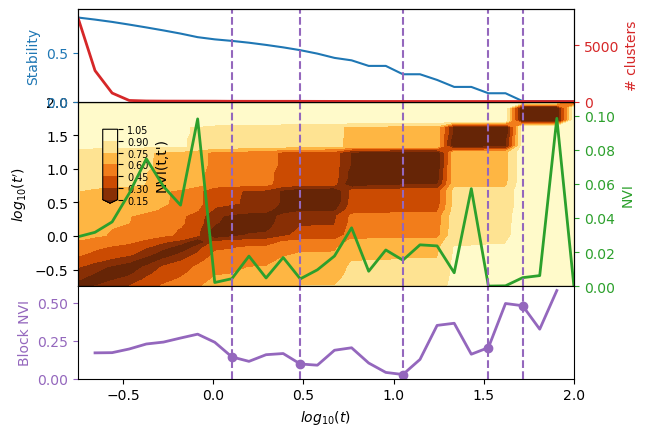

In [8]:
#here we choose the file
if expanded:
    best_file = 0
else:
    best_file = 0

#plot the results for the communiy detect
with open(files[best_file], 'rb') as f:
    all_results = pickle.load(f)
results = identify_optimal_scales(all_results)
_ = plotting.plot_scan(results,figure_name ='Figures/Fig10a.pdf')

#selectt the partittion to analyze
for cn in results['selected_partitions']:
    print('Partition n°', cn,'n° community: ', results['number_of_communities'][cn],
          'log10 Markov time: ',round(np.log10(results['scales'][cn]),2))
    
if expanded: 
    bp=37
else:
    bp=19

In [9]:
def compute_I_I(IRA,C,edges_w):
    
    count_edg=0
    
    IRAconnections_out = list(C.out_edges(IRA,data=True))
    
    for from_node,to_node,weight in IRAconnections_out:
        
        if to_node in IRA and from_node in IRA:
            
            count_edg += weight['weight']

    return round((count_edg/edges_w)*100,2)

def analyze_community(G,community,type_= 'ego',clouds=True):
    
    best_partition = all_results['community_id'][community]
    
    if type_ == 'expanded':
        nodes_to_comm = {i:j for i,j in zip(list( temporary.values()),best_partition)}
    else:
        nodes_to_comm = {i:j for i,j in zip(G.nodes(),best_partition)}
    
    n_communities = np.unique(list(nodes_to_comm.values()))
    
    
    print('N° of communities: ', len(n_communities))
    communities_,infl_per_comm_,check_accounts_conn_=[],[],[]
    
    if not len(G.nodes()) == len(best_partition):
        print('check it out!')
    
    prova = []
    communities = {}
    for idx in n_communities:
        
        #total nodes
        N = set([str(i) for i,j in nodes_to_comm.items() if (j==idx and i in users_account and i in users_opinion)])
        
        if len(N)/len(G.nodes())<0.1:
            continue
        
        for i in N:
            communities[i] = str(idx)
        
        print('Analyzing community n°: ',idx+1)
        
        #Ira nodes
        IRAnodes = set([i for i in N if Putin.fuck(i)])
        #non Ira nodes
        NIRAnodes = set([i for i in N if i not in IRAnodes])
        
        #get sugraph from the N nodes
        C = G.subgraph(N).copy()  
        edges_w = C.size(weight='weight')
        n_connections = C.size(weight=None)
        
        #return C,IRAnodes
        temp,infl_per_comm = [],[]
        
        temp.append(idx)
        temp.append(len(N))
        temp.append(edges_w)
        temp.append(n_connections)
        temp.append(len(IRAnodes))

        #here we compute the links from IRA to [non-IRA, IRA] and from 
        #non-IRA to IRA and normalize to their sum.
        ira_non,non_ira,ira_ira = 0,0,0
        normalization = 0
        for edge in C.edges(data=True):
            
            if Putin.fuck(edge[0]) and Putin.fuck(edge[1])==False:
                
                ira_non += edge[2]['weight']
                normalization += edge[2]['weight']
                
            elif Putin.fuck(edge[0])==False and Putin.fuck(edge[1]):
                
                non_ira += edge[2]['weight']
                normalization += edge[2]['weight']
                
            elif Putin.fuck(edge[0]) and Putin.fuck(edge[1]):
                
                ira_ira += edge[2]['weight']
                normalization += edge[2]['weight']
                
        for group in [ira_non,non_ira,ira_ira]:
            
            if normalization > 0:
                
                temp.append(round((group/normalization)*100,2))
            
            else:
                
                temp.append(0)
          
        #Here we count the number of users supporting each candidate and normalize over the sum.
        #Notice some users may not be in the dataset.This is becasue we ar econsidering the aggreated 
        #network.
        
        Tr = {i:user_strump2[i] for i in user_strump2 if  ( user_strump2[i]>0 and i in N )}
        Cl = {i:abs(user_strump2[i]) for i in user_strump2 if ( user_strump2[i]<0 and i in N)}
        U = [i for i in user_strump2 if ( user_strump2[i]==0 and i in N)]

        ST,WT = get_get_outliers(Tr)
        SC,WC = get_get_outliers(Cl)
        
        opinion_norm  = len(U)+len(ST)+len(WT)+len(SC)+len(WC)
        
        for class_ in [U,ST,WT,SC,WC]:
                temp.append(round(len(class_)/opinion_norm*100,2))

        #set of influencers
        influencers = set([i for i in np.concatenate([list(i) for i in infleuncers_per_cat.values()]) if \
                           (i in C.nodes() and i not in IRAnodes)])
        
        #S, NV, NF and V
        suspended_nodes = set([i for i in NIRAnodes if (users_account[i] == 'Suspended' and i not in influencers )])
        not_found_nodes = set([i for i in NIRAnodes if (users_account[i] == 'Not found' and i not in influencers)])
        not_verif_nodes = set([i for i in NIRAnodes if (users_account[i] == 'Not verified' and i not in influencers)])
        verif_nodes     = set([i for i in NIRAnodes if (users_account[i] == 'Verified' and i not in influencers)])
        
        normalization = len(suspended_nodes) + len(not_found_nodes) \
                        + len(not_verif_nodes) + len(verif_nodes) + len(IRAnodes)
        
    
        for class_ in [not_found_nodes,not_verif_nodes,suspended_nodes,verif_nodes,IRAnodes]:
            
            if normalization>0:
            
                temp.append(round((len(class_)/normalization)*100,2))
            
            else:
                
                temp.append(0)   
        
        infl_per_comm.append(idx)
        for category in infleuncers_per_cat:
            
            infl_per_comm.append(len(N & set(infleuncers_per_cat[category])))
      
        #table for connections
        check_accounts_conn = []
        check_accounts_conn.append(idx)
        check_accounts_conn.append(edges_w)
        
        #I focus on the connections between the IRA and the other groups
        IRAconnections_out = list(C.out_edges(IRAnodes,data=True))
        IRAconnections_in = list(C.in_edges(IRAnodes,data=True))
        
        for to_list in tqdm([suspended_nodes, not_found_nodes, 
                             not_verif_nodes,verif_nodes,influencers]):
            
            count_edg,count_edg_to,count_edg_from = 0,0,0
            check_accounts_nodes_i,check_accounts_nodes_ni = set(),set()
            
            for from_node,to_node,weight in IRAconnections_out:
                
                if to_node in to_list:
                    
                    check_accounts_nodes_i.add(from_node)
                    check_accounts_nodes_ni.add(to_node)
                    count_edg_to += weight['weight']
                    count_edg += weight['weight']
                    
            for to_node,from_node,weight in IRAconnections_in:
                
                if to_node in to_list:
                    
                    check_accounts_nodes_i.add(from_node)
                    check_accounts_nodes_ni.add(to_node)
                    count_edg_from += weight['weight']
                    count_edg += weight['weight'] 
          
            check_accounts_conn.append(len(check_accounts_nodes_i))
            check_accounts_conn.append(len(check_accounts_nodes_ni))
            check_accounts_conn.append(round((count_edg/edges_w)*100,2))
            check_accounts_conn.append(round((count_edg_to/edges_w)*100,2))
            check_accounts_conn.append(round((count_edg_from/edges_w)*100,2))
            
            
        #IRA in connections
        ira_to_ira = compute_I_I(IRAnodes,C,edges_w)
        check_accounts_conn.append(ira_to_ira)
        
        #these are the 3 final tables
        check_accounts_conn_.append(check_accounts_conn)
        
        infl_per_comm_.append(infl_per_comm)      
        
        communities_.append(temp)
        
        if clouds:
            nos = [int(i) for i in N if len(i)!=64]
            pd.DataFrame(Counter(hash_table[(hash_table['from'].isin(nos)) & (hash_table['to'].isin(nos))]['hash'])\
                 .most_common(1000),columns=['hash','count'])\
                 .to_csv(section_two_path + f'{community}_{idx}.csv') 
       
    general_prop = pd.DataFrame(communities_,
                        columns=['Community','N','Wsize','edges','N IRA ',
                                 'IRA to non-IRA','non-IRA to IRA','IRA to IRA',
                                 'U','ST','WT','SC','WC','Not Found', 'Not Verified',
                                 'Suspended', 'Verified','IRA'])
         
    top_influencers = pd.DataFrame( infl_per_comm_,
                            columns=np.concatenate([['Community'],\
                            [abbr_to_good[i] for i in infleuncers_per_cat.keys()]]))   

    conections = pd.DataFrame(check_accounts_conn_,
                              columns=[ 'Community','Wsize','IRA0','SUS','IRA0-SUS Edges', 'IRA->SUS','SUS->IRA', 'IRA1',
                                        'NF','IRA-NF Edges','IRA->NF','NF->IRA', 'IRA2','NV','IRA-NV Edges',
                                        'IRA->NV','NV->IRA', 'IRA3','V','IRA-V Edges','IRA->V','V->IRA', 'IRA4','I',
                                        'IRA-I Edges','IRA->I','I->IRA', 'IRA-IRA'])
    
    if type_ == 'ego':
        with open(section1_data_path+'top_communities.txt','w') as file:
            file.write(json.dumps(communities)+'\n')
        
    return general_prop,top_influencers,conections

In [11]:
#
for community in [bp]:
    print('\n')
    print(f'--- Partition n° {community} ---')
    #C,idx,accountstype,all_accounts=analyze_community(G,community)
    a,b,account_conn = analyze_community(G,community,type_= None)



--- Partition n° 19 ---
N° of communities:  5
Analyzing community n°:  1


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.45it/s]


Analyzing community n°:  2


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 87.00it/s]


In [12]:
print(b[b.Community.isin([0,2])].T.to_latex())

\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
Community          &   0 \\
Fake               &  97 \\
Extreme bias right &  97 \\
Right              &  96 \\
Right leaning      &  79 \\
Center             &  53 \\
Left leaning       &  27 \\
Left               &  11 \\
Extreme bias Left  &  13 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_22766/3772972901.py:1: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [13]:
print(a[a.Community.isin([0,2])].T.round(1).to_latex())

\begin{tabular}{lr}
\toprule
{} &         0 \\
\midrule
Community      &       0.0 \\
N              &  135846.0 \\
Wsize          &  789891.0 \\
edges          &  288648.0 \\
N IRA          &     160.0 \\
IRA to non-IRA &      77.6 \\
non-IRA to IRA &      22.0 \\
IRA to IRA     &       0.3 \\
U              &       1.8 \\
ST             &       9.5 \\
WT             &      76.6 \\
SC             &       1.8 \\
WC             &      10.3 \\
Not Found      &      21.2 \\
Not Verified   &      56.6 \\
Suspended      &      20.3 \\
Verified       &       1.7 \\
IRA            &       0.1 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_22766/2459489170.py:1: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [14]:
account_conn[['Community',
                'Wsize',
                'IRA0','SUS','IRA0-SUS Edges', 
                'IRA1','NF','IRA-NF Edges',
                'IRA2','NV','IRA-NV Edges',
                'IRA3','V','IRA-V Edges','IRA->I','I->IRA',
                'IRA-IRA']][account_conn.Community.isin([0,1,2])]

,Community,Wsize,IRA0,SUS,IRA0-SUS Edges,IRA1,NF,IRA-NF Edges,IRA2,NV,IRA-NV Edges,IRA3,V,IRA-V Edges,IRA->I,I->IRA,IRA-IRA
0,0,789891.0,151,27525,27.11,139,28768,17.73,154,76612,47.18,129,2297,2.13,0.11,5.40,0.34
1,1,197463.0,110,2280,12.94,108,2760,5.75,112,15151,42.28,110,3455,24.45,0.00,10.25,4.32


In [15]:
account_conn[['IRA0-SUS Edges', 'IRA-NF Edges','IRA-NV Edges','IRA-V Edges',
                'IRA-IRA','IRA->I','I->IRA']].sum(axis=1)

0    100.00
1     99.99
dtype: float64

In [16]:
tab=account_conn[['Community','IRA->SUS','SUS->IRA','IRA->NF','NF->IRA','IRA->NV','NV->IRA',
                  'IRA->V','V->IRA','IRA->I','I->IRA','IRA-IRA']][account_conn.Community.isin([0,1,2])]
tab

,Community,IRA->SUS,SUS->IRA,IRA->NF,NF->IRA,IRA->NV,NV->IRA,IRA->V,V->IRA,IRA->I,I->IRA,IRA-IRA
0,0,21.74,5.37,16.13,1.60,39.59,7.59,0.04,2.09,0.11,5.40,0.34
1,1,0.39,12.55,0.69,5.06,2.70,39.58,0.01,24.44,0.00,10.25,4.32


In [17]:
print(tab[tab.Community.isin([0,2])].T.to_latex())

\begin{tabular}{lr}
\toprule
{} &      0 \\
\midrule
Community &   0.00 \\
IRA->SUS  &  21.74 \\
SUS->IRA  &   5.37 \\
IRA->NF   &  16.13 \\
NF->IRA   &   1.60 \\
IRA->NV   &  39.59 \\
NV->IRA   &   7.59 \\
IRA->V    &   0.04 \\
V->IRA    &   2.09 \\
IRA->I    &   0.11 \\
I->IRA    &   5.40 \\
IRA-IRA   &   0.34 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_22766/414234144.py:1: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



# Cloudwords

In [18]:
#https://www.kaggle.com/code/tarzon/custom-word-cloud
def makeImage(file):
    
    text={i['hash']:i['count'] for _,i in pd.read_csv(file).iterrows()}
    if text =={}:
        return 
    mask = np.array(Image.open("/home/matteo/IRA_paper/CW.png"))
    
    def transform_format(val):
        if val == 0:
            return 255
        else:
            return val
    
    transformed_mask = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)

    #for i in range(len(mask)):
    #    transformed_mask[i] = list(map(transform_format, mask[i]))
    
    wc = WordCloud(background_color="white", max_words=100,contour_color='#023075',contour_width=2,
                   mask=mask)
    wc.width = 1400
    wc.height = 1400
    # generate word cloud
    wc.generate_from_frequencies(text)
    
  

    # show
    plt.figure(figsize=[15,15])#
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    # store to file
    #plt.savefig(f"Figures/cloud_{file.split('/')[-1].split('.')[0]}.pdf", format="pdf")
    
   


    plt.show()

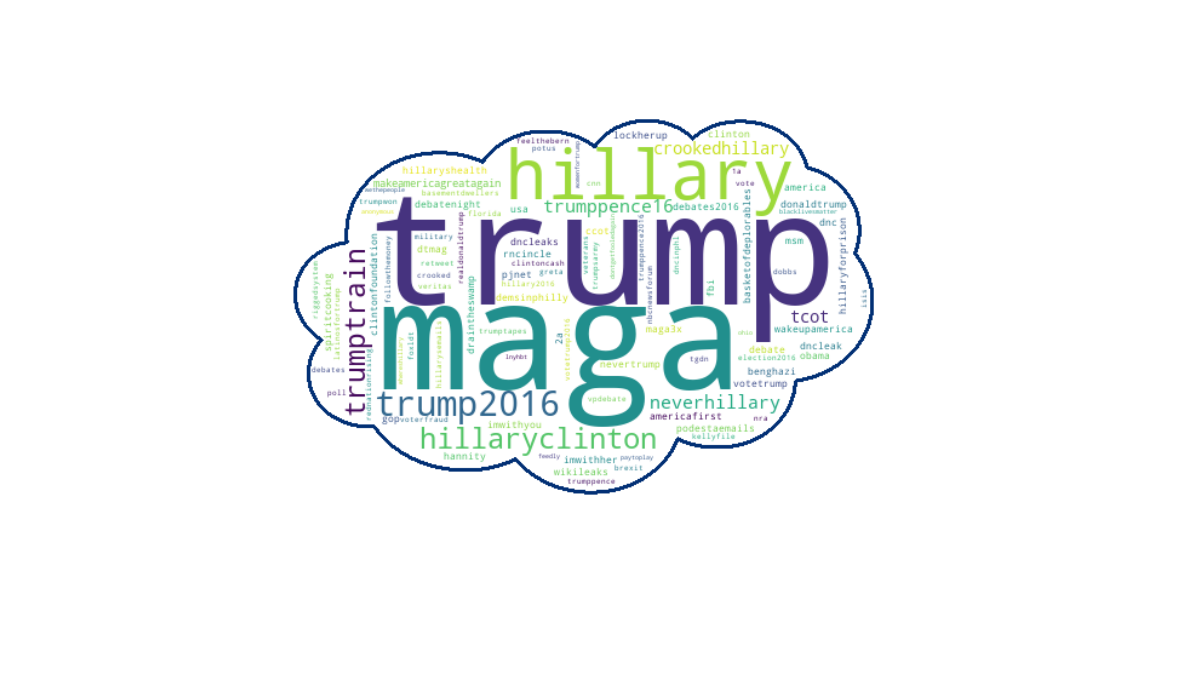

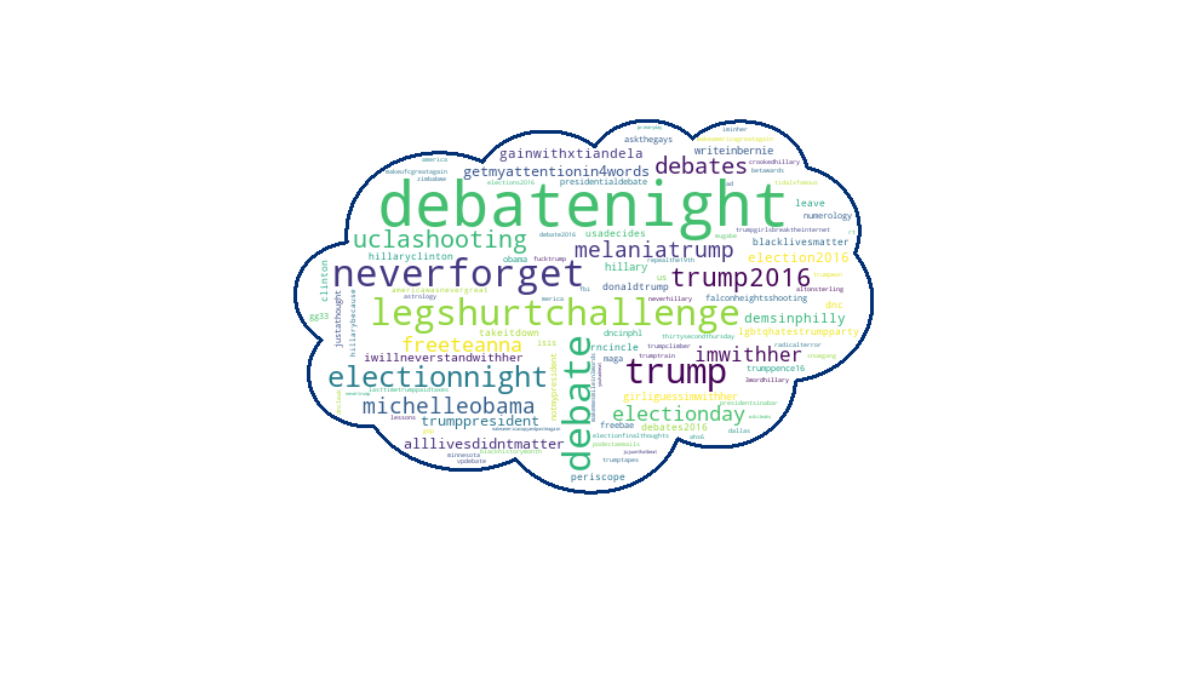

In [19]:
for file in ['37_0.csv','37_1.csv']:
    a=makeImage(section_two_path + file)

# Sankey plot

In [20]:
#sankey
clinton_color = [c/255 for c in [0, 0, 255]]
trump_color = [c/255 for c in [205,38,38]]
undecided_color = [c/255 for c in [0,255,255]]
from matplotlib import colors
import matplotlib
import plotly
matplotlib.colors.to_hex(clinton_color, keep_alpha=True)


def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2
            for (c1, c2) in zip(rgb, bg_rgb)]


alpha = 0.9
alpha_ = 0.2
rgb = colors.colorConverter.to_rgb('red')
trumplink= make_rgb_transparent(rgb, (1, 1, 1), alpha)
trumplink=matplotlib.colors.to_hex(trumplink, keep_alpha=True)

rgb = colors.colorConverter.to_rgb('red')
trumplinkin= make_rgb_transparent(rgb, (1, 1, 1), alpha_)
trumplinkin=matplotlib.colors.to_hex(trumplinkin, keep_alpha=True)

rgb = colors.colorConverter.to_rgb('blue')
clintonlink= make_rgb_transparent(rgb, (1, 1, 1), alpha)
clintonlink=matplotlib.colors.to_hex(clintonlink, keep_alpha=True)

rgb = colors.colorConverter.to_rgb('blue')
clintonlinkin= make_rgb_transparent(rgb, (1, 1, 1), alpha_)
clintonlinkin=matplotlib.colors.to_hex(clintonlinkin, keep_alpha=True)


color = {0:'rgb'+str(plotly.colors.hex_to_rgb(trumplink)),
        1:'rgb'+str(plotly.colors.hex_to_rgb(clintonlink)),
        2:'rgb'+str(plotly.colors.hex_to_rgb(trumplinkin)),
        3:'rgb'+str(plotly.colors.hex_to_rgb(clintonlinkin))}


In [26]:
tab=account_conn[['Community',
                  'IRA->SUS','SUS->IRA','IRA->NF','NF->IRA','IRA->NV','NV->IRA', 'IRA->V',
                 'V->IRA','IRA->I','I->IRA','IRA-IRA']][account_conn.Community.isin([0,1])]

tab

,Community,IRA->SUS,SUS->IRA,IRA->NF,NF->IRA,IRA->NV,NV->IRA,IRA->V,V->IRA,IRA->I,I->IRA,IRA-IRA
0,0,21.74,5.37,16.13,1.60,39.59,7.59,0.04,2.09,0.11,5.40,0.34
1,1,0.39,12.55,0.69,5.06,2.70,39.58,0.01,24.44,0.00,10.25,4.32


In [27]:
print(tab.T.to_latex())

\begin{tabular}{lrr}
\toprule
{} &      0 &      1 \\
\midrule
Community &   0.00 &   1.00 \\
IRA->SUS  &  21.74 &   0.39 \\
SUS->IRA  &   5.37 &  12.55 \\
IRA->NF   &  16.13 &   0.69 \\
NF->IRA   &   1.60 &   5.06 \\
IRA->NV   &  39.59 &   2.70 \\
NV->IRA   &   7.59 &  39.58 \\
IRA->V    &   0.04 &   0.01 \\
V->IRA    &   2.09 &  24.44 \\
IRA->I    &   0.11 &   0.00 \\
I->IRA    &   5.40 &  10.25 \\
IRA-IRA   &   0.34 &   4.32 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_22766/1268620064.py:1: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [28]:
sources,targets,values,colors=[],[],[],[]


for cnt,us in enumerate(list(tab['Community'])):
    tmp=tab[tab['Community']==us]
    for cnt3,type_ in enumerate(['IRA->SUS','IRA->NF','IRA->NV','IRA->V','IRA->I']):
        val=list(tmp[type_])[0]
        sources.append(cnt)
        targets.append(cnt3+2)
        values.append(round(val,1))
        colors.append(color[cnt+2])

In [29]:
for cnt,us in enumerate(list(tab['Community'])):
    tmp=tab[tab['Community']==us]
    for cnt3,type_ in enumerate(['SUS->IRA','NF->IRA','NV->IRA','V->IRA','I->IRA']):
        val=list(tmp[type_])[0]
        sources.append(cnt)
        targets.append(cnt3+2)
        values.append(round(val,1))
        colors.append(color[cnt])

In [30]:
import plotly.graph_objects as go
import kaleido
fig = go.Figure(data=[go.Sankey(
        orientation = "v",
    arrangement = "snap",
    node = dict(
      pad = 50,
      thickness = 12,
      line = dict(color = "black", width = 0.2),
      label = ["0","1", 'Suspended','Not Found', 'Not Verified', 'Verified','Infl'],
      color = ["darkred","darkblue",'lightgray','yellow','Black','green']
    ),
    link = dict(
      source = sources, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = targets,
      value = values,
      color =  colors
  ))])

#fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.update_layout(
    title_text="",
    font=dict(size=20,color='black'),
    #width=800,
    #height=800,
)

#fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.write_image('Figures/Fig12b.svg')#, engine="kaleido")
fig.show()

## communies overlap

In [31]:
communitego=json.load(open('Final_codes_and_data/data/communities/partition_1.txt'))
communitexpanded=json.load(open('Final_codes_and_data/data/communities/partition_expresults_60_1_75.txt'))


FileNotFoundError: [Errno 2] No such file or directory: 'Final_codes_and_data/data/communities/partition_1.txt'

In [32]:
or_=set([i[0] for i in communitego.items() if  i[1]=='0'])
exp=set([i[0] for i in communitexpanded.items() if  i[1]=='0'])
len(or_ & exp)/len(or_)

NameError: name 'communitego' is not defined

In [33]:
or_=set([i[0] for i in communitego.items() if  i[1]=='1'])
exp=set([i[0] for i in communitexpanded.items() if  i[1]=='1'])
len(or_ & exp)/len(or_)

NameError: name 'communitego' is not defined

In [34]:
or_=set([i[0] for i in communitego.items() if  i[1]=='1'])
exp=set([i[0] for i in communitexpanded.items() if  i[1]=='2'])
len(or_ & exp)/len(or_)

NameError: name 'communitego' is not defined

In [ ]:
np.unique( [i[1] for i in communitexpanded.items() ], return_counts=True)

In [ ]:
23501/len(communitexpanded)